This notebook uses blurr, integration library between fastai and huggingface to train a multilabel classification model to identify the toxic comments from the dataset.

DataSet: [Jigsaw Toxicity Prediction](https://huggingface.co/datasets/jigsaw_toxicity_pred)

In [ ]:
#hide
!pip install fastai -q --upgrade
!pip install nbdev -q --upgrade
!pip install -q huggingface-hub>0.0.10
!pip install ohmeow-blurr -q --upgrade

     |████████████████████████████████| 204kB 7.2MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 245kB 12.8MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 2.3MB 12.9MB/s 
     |████████████████████████████████| 1.2MB 52.3MB/s 
     |████████████████████████████████| 122kB 58.7MB/s 
     |████████████████████████████████| 245kB 51.7MB/s 
     |████████████████████████████████| 3.3MB 54.0MB/s 
     |████████████████████████████████| 901kB 45.9MB/s 
ERROR: transformers 4.6.1 has requirement huggingface-hub==0.0.8, but you'll have huggingface-hub 0.0.10 which is incompatible.


In [ ]:
#hide
%pip install datasets -q --upgrade #datasets & evaluation metrics for nlp from HF

# Imports

In [ ]:
import torch
from datasets import load_dataset

from transformers import *
from fastai.text.all import * 

from blurr.data.all import *
from blurr.modeling.all import *

In [ ]:
#hide
from nbdev.showdoc import show_doc

from fastai import __version__ as fastai_version
from torch import __version__ as torch_version
from transformers import __version__ as transformers_version

In [ ]:
print(f'Pytorch: {torch_version} Fastai: {fastai_version} HF Transformers: {transformers_version}')

Pytorch: 1.8.1+cu101 Fastai: 2.3.1 HF Transformers: 4.6.1


In [ ]:
#cuda
#torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #0: Tesla T4


# Get your data

In [ ]:
%mkdir data

In [ ]:
raw_data = load_dataset('civil_comments', split='train[:1%]')

Using custom data configuration default


Dataset civil_comments downloaded and prepared to /root/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab. Subsequent calls will reuse this data.


In [ ]:
len(raw_data)

18049

In [ ]:
toxic_df = pd.DataFrame(raw_data)
toxic_df.head()

,identity_attack,insult,obscene,severe_toxicity,sexual_explicit,text,threat,toxicity
0,0.000000,0.00000,0.0,0.000000,0.0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.0,0.000000
1,0.000000,0.00000,0.0,0.000000,0.0,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.0,0.000000
2,0.000000,0.00000,0.0,0.000000,0.0,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.0,0.000000
3,0.000000,0.00000,0.0,0.000000,0.0,Is this something I'll be able to install on my site? When will you be releasing it?,0.0,0.000000
4,0.021277,0.87234,0.0,0.021277,0.0,haha you guys are a bunch of losers.,0.0,0.893617


In [ ]:
toxic_df.columns

NameError: ignored

In [ ]:
label_columns = list(toxic_df.columns[1:]);
label_columns.remove('text');
label_columns

['insult',
 'obscene',
 'severe_toxicity',
 'sexual_explicit',
 'threat',
 'toxicity']

In [ ]:
toxic_df.round({col: 0 for col in label_columns}) #round the toxic dataframe to a var number of decimal places
toxic_df = toxic_df.convert_dtypes()

toxic_df.head()

,identity_attack,insult,obscene,severe_toxicity,sexual_explicit,text,threat,toxicity
0,0.000000,0.00000,0.0,0.000000,0.0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.0,0.000000
1,0.000000,0.00000,0.0,0.000000,0.0,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.0,0.000000
2,0.000000,0.00000,0.0,0.000000,0.0,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.0,0.000000
3,0.000000,0.00000,0.0,0.000000,0.0,Is this something I'll be able to install on my site? When will you be releasing it?,0.0,0.000000
4,0.021277,0.87234,0.0,0.021277,0.0,haha you guys are a bunch of losers.,0.0,0.893617


# Get your huggingface objects

In [ ]:
model_cls = AutoModelForSequenceClassification

In [ ]:
#Define the pretrained model that we want to use

#The DistilRoBERTa model distilled from the RoBERTa model roberta-base checkpoint.
#Compressed model from roberta  having 35% less params & runs twice faster & preserves 95%
pretrained_model_name = 'distilroberta-base' 

Pretrained models from HuggingFace can be found here
https://huggingface.co/transformers/pretrained_models.html

Community uploaded models
https://huggingface.co/models.

- `t5`: :class:`~transformers.T5Config` (T5 model)
- `distilbert`: :class:`~transformers.DistilBertConfig` (DistilBERT model)
- `albert`: :class:`~transformers.AlbertConfig` (ALBERT model)
- `camembert`: :class:`~transformers.CamembertConfig` (CamemBERT model)
- `xlm-roberta`: :class:`~transformers.XLMRobertaConfig` (XLM-RoBERTa model)
- `longformer`: :class:`~transformers.LongformerConfig` (Longformer model)
- `roberta`: :class:`~transformers.RobertaConfig` (RoBERTa model)
- `reformer`: :class:`~transformers.ReformerConfig` (Reformer model)
- `bert`: :class:`~transformers.BertConfig` (Bert model)
- `openai-gpt`: :class:`~transformers.OpenAIGPTConfig` (OpenAI GPT model)
- `gpt2`: :class:`~transformers.GPT2Config` (OpenAI GPT-2 model)
- `transfo-xl`: :class:`~transformers.TransfoXLConfig` (Transformer-XL model)
- `xlnet`: :class:`~transformers.XLNetConfig` (XLNet model)
- `xlm`: :class:`~transformers.XLMConfig` (XLM model)
- `ctrl` : :class:`~transformers.CTRLConfig` (CTRL model)
- `flaubert` : :class:`~transformers.FlaubertConfig` (Flaubert model)
- `electra` : :class:`~transformers.ElectraConfig` (ELECTRA model)

In [ ]:
config = AutoConfig.from_pretrained(pretrained_model_name)  # Download configuration from S3 and cache.

In [ ]:
config

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [ ]:
config.num_labels = len(label_columns)

NameError: ignored

In [ ]:
doc(BLURR.get_hf_objects)

In [ ]:
AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, )

In [ ]:

BLURR.get_hf_objects()

In [ ]:
#Returns the architecture (str), config (obj), tokenizer (obj), and model (obj) given at minimum a pre-trained model name or path. Specify a task to ensure the right "AutoModelFor" is used to create the model.

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(
    pretrained_model_name, 
    model_cls=model_cls,
    config=config)

In [ ]:
print(hf_arch), print(type(hf_config)), print(type(hf_tokenizer)), print(type(hf_model))

roberta
<class 'transformers.models.roberta.configuration_roberta.RobertaConfig'>
<class 'transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast'>
<class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>


(None, None, None, None)

# Build your DataBlock & DataLoaders

In [ ]:
doc(HF_TextBlock)

HF_TextBlock handles setting up the HF_TokenizerTransform transforms and HF_BatchTransform transform regardless of data source (e.g., this will work with files, DataFrames, whatever).

HF_TokenizerTransform was inspired by this [article](http://dev.fast.ai/tutorial.transformers). It handles both the tokenization and numericalization traditionally split apart in the fastai text DataBlock API. Addtionally, it's been updated to add a prefix space for the huggingface architectures that need it.

You can pass a string or list into this Transform, the later being common in token classification tasks like named entity recognition.

build_hf_input uses fastai's @typedispatched decorator to provide for complete flexibility in terms of how your numericalized tokens are assembled, and also what you return via HF_BaseInput and as your targets. You can override this implementation as needed by assigning a type to the task argument (and optionally the tokenizer argument as well).

What you return here is what will be fed into your huggingface model.


In [ ]:
# Note how we have to configure the num_labels to the number of labels we are predicting. Given that our labels are already encoded, we use a MultiCategoryBlock with encoded=True and vocab equal to the columns with our 1's and 0's.
# single input 
# Define the datatypes of your item X,y
X = HF_TextBlock(hf_arch,
                 hf_config,
                 hf_tokenizer,
                 hf_model)
y = MultiCategoryBlock(encoded=True, vocab=label_columns)
blocks = (X, y)

In [ ]:
blocks

(<blurr.data.core.HF_TextBlock at 0x7fac41ef36d0>,
 <fastai.data.block.TransformBlock at 0x7fac66a73190>)

In [ ]:
doc(DataBlock)

In [ ]:
label_columns

['insult',
 'obscene',
 'severe_toxicity',
 'sexual_explicit',
 'threat',
 'toxicity']

In [ ]:
toxic_df.dtypes

identity_attack    float64
insult             float64
obscene            float64
severe_toxicity    float64
sexual_explicit    float64
text                string
threat             float64
toxicity           float64
dtype: object

In [ ]:
dblock = DataBlock(blocks=blocks, # Define the datatypes of your item
                   get_x=ColReader('text'), #where to get the X from
                   get_y=ColReader(label_columns), #where to get the y from
                   splitter=RandomSplitter(valid_pct=0.2, seed=42)) #how to split the data for training & validation

In [ ]:
dblock.summary(source=toxic_df)

Setting-up type transforms pipelines
0             0.000000  0.000000  ...     0.0  0.000000
1             0.000000  0.000000  ...     0.0  0.000000
2             0.000000  0.000000  ...     0.0  0.000000
3             0.000000  0.000000  ...     0.0  0.000000
4             0.021277  0.872340  ...     0.0  0.893617
...                ...       ...  ...     ...       ...
18044         0.000000  0.000000  ...     0.2  0.200000
18045         0.000000  0.000000  ...     0.0  0.000000
18046         0.000000  0.000000  ...     0.0  0.000000
18047         0.000000  0.000000  ...     0.0  0.000000
18048         0.000000  0.166667  ...     0.0  0.166667

[18049 rows x 8 columns]
Found 18049 items
2 datasets of sizes 14440,3609
Setting up Pipeline: ColReader -- {'cols': 'text', 'pref': '', 'suff': '', 'label_delim': None}
Setting up Pipeline: ColReader -- {'cols': ['insult', 'obscene', 'severe_toxicity', 'sexual_explicit', 'threat', 'toxicity'], 'pref': '', 'suff': '', 'label_delim': None} -> En

In [ ]:
dls = dblock.dataloaders(toxic_df, bs=16)

In [ ]:
b = dls.one_batch(); len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([16, 391]), torch.Size([16, 6]))

In [ ]:
b[0]

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'input_ids': tensor([[    0, 24268,  5257,  ...,     1,     1,     1],
         [    0,  1234,     6,  ...,     1,     1,     1],
         [    0,   140,    34,  ...,     1,     1,     1],
         ...,
         [    0,    38,  1395,  ...,     1,     1,     1],
         [    0,    38,   524,  ...,     1,     1,     1],
         [    0,    20,  6304,  ...,     1,     1,     1]], device='cuda:0')}

In [ ]:
b[1]

TensorMultiCategory([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667],
        [0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0')

# Training

With our DataLoaders built, we can now build our Learner and train. We'll use mixed precision so we can train with bigger batches

In [ ]:
model = HF_BaseModelWrapper(hf_model)

Same as nn.Module, but no need for subclasses to call super().__init__. This uses a model wrapper in order to pass named arguments into the huggingface model. We do this because all arguments for a given model are not all used or needed for each architecture, and fastai does not support passing in None.


In [ ]:
doc(Learner)

In [ ]:
learn = Learner(dls,
                model,
                opt_func=partial(Adam),
                loss_func=BCEWithLogitsLossFlat(), # multilabel classification loss_func, same as BCEWithLogitsLoss  but flattens the input & target
                metrics=partial(accuracy_multi, thresh=0.2),
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter).to_fp16()

learn.loss_func.thresh = 0.2
learn.create_opt() # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [ ]:
learn.blurr_summary()

HF_BaseModelWrapper (Input shape: 16 x 391)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 391 x 768      
Embedding                                 38603520   False     
Embedding                                 394752     False     
Embedding                                 768        False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
     

In [ ]:
doc(Learner.create_opt)

This method is called internally to create the optimizer, the hyper-parameters are then adjusted by what you pass to Learner.fit or your particular schedulers (see callback.schedule).

In [ ]:
#check the learner work for a sample
preds = model(b[0])
preds.logits.shape, preds

(torch.Size([16, 6]),
 SequenceClassifierOutput([('logits',
                            tensor([[-3.5993, -5.3291, -7.0173, -5.7250, -5.5425, -3.3405],
                                    [-4.1521, -5.5553, -7.3682, -6.2844, -5.9261, -3.7864],
                                    [-1.8160, -3.6050, -5.5187, -5.4348, -4.9802, -1.5784],
                                    [-2.9193, -4.6364, -4.9824, -3.6422, -2.1356, -1.8673],
                                    [-2.1799, -4.2955, -6.0301, -5.6385, -5.4961, -1.9690],
                                    [-1.5147, -3.8444, -5.5366, -5.6994, -4.1171, -1.3472],
                                    [-3.8328, -5.9142, -7.4598, -6.3970, -6.3127, -3.6225],
                                    [-4.5958, -5.7680, -7.6138, -6.4669, -6.2175, -4.1220],
                                    [-4.1937, -5.7697, -7.4271, -6.3916, -5.6011, -3.6791],
                                    [-4.1763, -5.9607, -7.3833, -6.1609, -6.1598, -3.8454],
                    

In [ ]:
print(len(learn.opt.param_groups))

3


SuggestedLRs(lr_min=5.248074739938602e-06, lr_steep=7.585775847473997e-07)

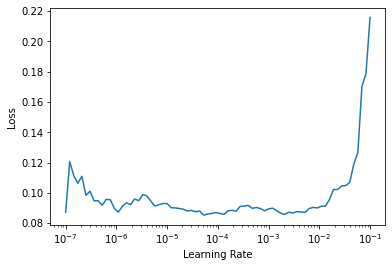

In [ ]:
learn.lr_find(suggestions=True)

In [ ]:
learn.fit_one_cycle(1, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.090206,0.088547,0.912626,00:57


In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=1.3460866057357635e-07, lr_steep=3.62389823749254e-06)

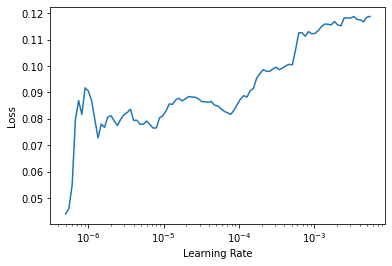

In [ ]:
learn.lr_find(suggestions=True, start_lr=5e-7, end_lr=1e-2)

In [ ]:
learn.fit_one_cycle(3, lr_max=slice(1e-7, 3e-6))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.091295,0.088013,0.913873,01:38
1,0.088233,0.087246,0.913965,01:37
2,0.087213,0.087196,0.914104,01:37


In [ ]:
learn.show_results(learner=learn, max_n=2)

,text,None,target
0,"As usual WW plumbing the depths for deeper meaning... that is unless it involves an issue on which they disagree then it is ridicule 24/7. Clever creating the Bundyland series complete with cartoon banner. Set the tone for the level of journalism to expect... journalism? ... fatastisticism. \n\nI did notice you soft pedaling the ridicule of David Fry identifying him as troubled. My guess is that has more to do with sympathy for his pot smoking withdrawl rants than respect for his politics. Respect is never a factor with liberals as evidenced by your series of vapid caricatures. \n\nDid you happen to see the stories actual journalists did on Refuge mis-managment, fires, floods, and the millions of Carp that are harassing the birds away from the Bird Refuge? The stories of arbitrary miss-management that are driving unemployment ever higher in eastern Oregon. Curry County Sheriff turning in his badge in frustration for lack of resources dud to dwindling tax base engineered by arbitrary over reaching Federal Government policies. Or how about the thousands of miles of roads proposed to be removed from Oregon wild lands, cutting off public and fire access? What is the one issue the people of Oregon demand universally? Access to the wild lands? You are not reporting that it is being taken away. More closed roads. More illegal Federal Police, guns drawn, stops... as reported by the Sheriff of Grant County. \n\nI suspect the real problem was real people you couldn't care less about were articulate, were actual victims, and made rational arguments you could not respond to. The exact opposite of the great unbathed OWS movement, apart from the paid organizers, that held downtown Portland hostage and trashed 3 park blocks for 3 weeks. \n\nShame on you. You missed some really great stories and even greater people... people who don't drink $5 cups of coffee.",,[]
1,"@motleycrew: You're right when you say that it is time to wonder about the differences between schools, and to do something about it.\n\nBut you've missed the point beyond that. This ""School Choice"" policy become a self-enforcing cycle: as attendance drops at a school, funding and staffing follow shortly there-after. As staff are lost and the remaining teachers are stretched even thinner the school struggles to provide the same programs as other schools. (Note that I saw this first-hand as music and other elective programs became harder and harder to enroll in during my 4 years at North). The lack of those programs encourage more families to request that their students be transferred to a different school. It's natural for those families to want the best education for their children, and they can't be blamed for this.\n\nBut here's the problem: It should surprise exactly no one that this option to transfer to a different school is over-overwhelmingly taken by more affluent families who...",,[]


In [ ]:
learn.loss_func.thresh = 0.7

In [ ]:
learn.blurr_predict("You are the biggest loser! go to hell")

[(((#2) ['insult','toxicity'],),
  (#1) [tensor([ True, False, False, False, False,  True])],
  (#1) [tensor([0.7143, 0.3579, 0.0679, 0.0543, 0.0276, 0.7736])])]

In [ ]:
learn.blurr_predict("Who the fuck you think you are!")

[(((#2) ['insult','toxicity'],),
  (#1) [tensor([ True, False, False, False, False,  True])],
  (#1) [tensor([0.7061, 0.6684, 0.1649, 0.2593, 0.0840, 0.8123])])]

In [ ]:
learn.loss_func.thresh = 0.02
comment = """
Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes. 
No enchiladas for them!
"""
learn.blurr_predict(comment)

[(((#3) ['insult','obscene','toxicity'],),
  (#1) [tensor([ True,  True, False, False, False,  True])],
  (#1) [tensor([0.3693, 0.1071, 0.0180, 0.0107, 0.0128, 0.5056])])]

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([3609, 6]), torch.Size([3609, 6]), torch.Size([3609]))